In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import sem, mannwhitneyu, kstest, pearsonr, bootstrap
from sklearn.linear_model import LinearRegression, RidgeCV
from my_utils import *
import pickle

from pathlib import Path
import sys
import warnings

In [2]:
import config.config as config

arg = config.ConfigGain()
arg.device = 'cpu'

In [3]:
def config_colors():
    colors = {'abort_c': '#ed2024', 'attempt_c': '#9E9F9F',
              'withvalue_c': 'lightseagreen', 'withoutvalue_c': 'salmon', 'holistic_c': 'blue',
              'RNN_c': '#faaf3b'}
    return colors

In [4]:
plt.rcParams['pdf.fonttype'] = '42'
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['mathtext.default'] = 'it'
plt.rcParams['mathtext.fontset'] = 'custom'

In [5]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

In [6]:
# agents checkpoints path
actorvalue_agents_path = Path('D:/quitting_data/agents_no_curriculum/ActorCritic')
actornovalue_agents_path = Path('D:/quitting_data/agents_no_curriculum/Actor_novalueCritic')
actorholistic_agents_path = Path('D:/quitting_data/agents_no_curriculum/Actor_holisticCritic')
# figure path
figure_path = Path('C:/Users/rz31/Desktop/skipping_figure')
# data path
analysis_data_path = Path('D:/quitting_data/analysis_data')

In [7]:
from Actor_novalue import Actor as Actor_novalue
from Actor import Actor
from Actor_holistic import Actor as Actor_holistic
from Critic import Critic

## 2F

In [8]:
seeds_actorvalue = seeds_actornovalue = seeds_actorholistic = np.arange(50)

In [9]:
actorvalue_agents_training_progress = []
actornovalue_agents_training_progress = []
actorholistic_agents_training_progress = []

for seed in seeds_actorvalue:
    actorvalue_agents_training_progress.append(pd.read_csv(list((
                                        actorvalue_agents_path / f'seed{seed}').glob('*.csv'))[0]))
for seed in seeds_actornovalue:
    actornovalue_agents_training_progress.append(pd.read_csv(list((
                                        actornovalue_agents_path / f'seed{seed}').glob('*.csv'))[0]))
    
for seed in seeds_actorholistic:
    actorholistic_agents_training_progress.append(pd.read_csv(list((
                                        actorholistic_agents_path / f'seed{seed}').glob('*.csv'))[0]))
    
actorvalue_agents_reward_rate = np.array([v.reward_rate.values for v in actorvalue_agents_training_progress])
actornovalue_agents_reward_rate = np.array([v.reward_rate.values for v in actornovalue_agents_training_progress])
actorholistic_agents_reward_rate = np.array([v.reward_rate.values for v in actorholistic_agents_training_progress])
actorvalue_agents_skip_frac = np.array([v['skipped_fraction'].values for v in actorvalue_agents_training_progress])
actornovalue_agents_skip_frac = np.array([v['skipped_fraction'].values for v in actornovalue_agents_training_progress])
actorholistic_agents_skip_frac = np.array([v['skipped_fraction'].values for v in actorholistic_agents_training_progress])
actorvalue_agents_trial_dur = np.array([v['mean_steps'].values for v in actorvalue_agents_training_progress])
actornovalue_agents_trial_dur = np.array([v['mean_steps'].values for v in actornovalue_agents_training_progress])
actorholistic_agents_trial_dur = np.array([v['mean_steps'].values for v in actorholistic_agents_training_progress])
actorvalue_agents_travel_dist = np.array([v['traveled_distance'].values for v in actorvalue_agents_training_progress])
actornovalue_agents_travel_dist = np.array([v['traveled_distance'].values for v in actornovalue_agents_training_progress])
actorholistic_agents_travel_dist = np.array([v['traveled_distance'].values for v in actorholistic_agents_training_progress])

In [10]:
mean_reward_rate = [actorholistic_agents_reward_rate.mean(axis=0), actornovalue_agents_reward_rate.mean(axis=0), 
                    actorvalue_agents_reward_rate.mean(axis=0)]
sem_reward_rate = [sem(actorholistic_agents_reward_rate, axis=0), sem(actornovalue_agents_reward_rate, axis=0), 
                   sem(actorvalue_agents_reward_rate, axis=0)]
mean_skip_frac = [np.nanmean(actorholistic_agents_skip_frac, axis=0), np.nanmean(actornovalue_agents_skip_frac, axis=0), 
                  np.nanmean(actorvalue_agents_skip_frac, axis=0)]
sem_skip_frac = [sem(actorholistic_agents_skip_frac, axis=0, nan_policy='omit'),
                 sem(actornovalue_agents_skip_frac, axis=0, nan_policy='omit'), 
                 sem(actorvalue_agents_skip_frac, axis=0, nan_policy='omit')]
mean_trial_dur = [actorholistic_agents_trial_dur.mean(axis=0), actornovalue_agents_trial_dur.mean(axis=0), 
                  actorvalue_agents_trial_dur.mean(axis=0)]
sem_trial_dur = [sem(actorholistic_agents_trial_dur, axis=0), sem(actornovalue_agents_trial_dur, axis=0), 
                 sem(actorvalue_agents_trial_dur, axis=0)]
mean_travel_dist = [actorholistic_agents_travel_dist.mean(axis=0), actornovalue_agents_travel_dist.mean(axis=0), 
                    actorvalue_agents_travel_dist.mean(axis=0)]
sem_travel_dist = [sem(actorholistic_agents_travel_dist, axis=0), sem(actornovalue_agents_travel_dist, axis=0), 
                   sem(actorvalue_agents_travel_dist, axis=0)]

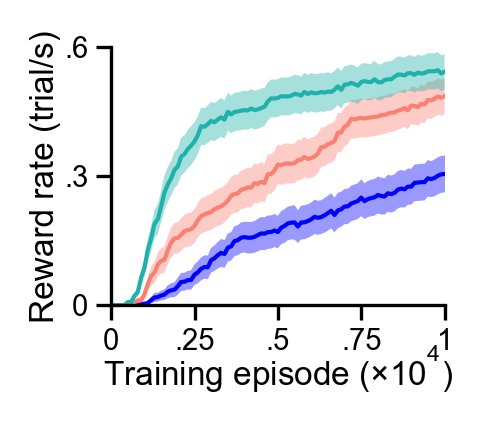

In [11]:
width = 1.5; height = 1.3
MAX_TRAINING_T = 10000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.6, 3), 2)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training episode ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

for ymean, ysem, color, label, xdata in zip(mean_reward_rate, sem_reward_rate,
                                            [holistic_c, withoutvalue_c, withvalue_c],
                                            ['Agent 1', 'Agent 2', 'Agent 3'],
                                            [actorholistic_agents_training_progress[0].episode.values,
                                             actornovalue_agents_training_progress[0].episode.values,
                                             actorvalue_agents_training_progress[0].episode.values]):
    ax.plot(xdata, ymean, lw=lw, clip_on=True, c=color, label=label)
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=color, alpha=0.4)

#ax.legend(fontsize=fontsize, frameon=False, loc=[0.28, 1], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_training_scratch'), orientation='portrait', format='pdf', transparent=True)

## S3C

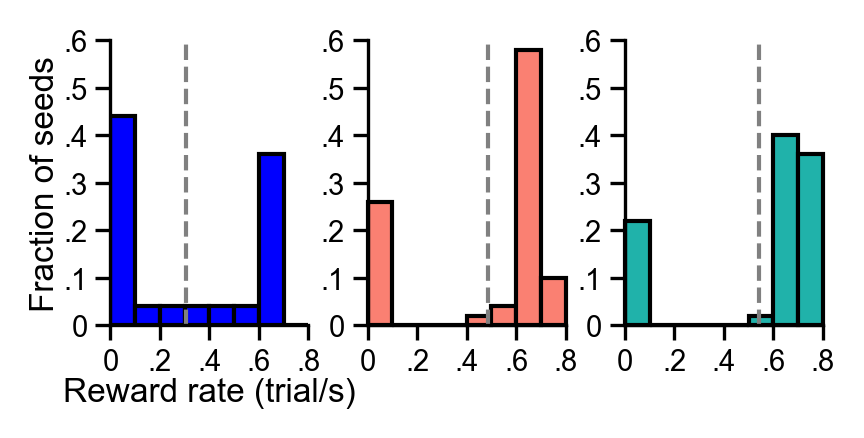

In [12]:
width = 2.7; height = 1.3

yticks = np.around(np.linspace(0, 0.6, 7), 1)
xticks = [0, 0.2, 0.4, 0.6, 0.8]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(131)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_ylabel('Fraction of seeds', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.18)
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

bins = np.linspace(0, 0.8, 9)
data = actorholistic_agents_reward_rate[:, 99]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=holistic_c, edgecolor='k', lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(132)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = actornovalue_agents_reward_rate[:, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withoutvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(133)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = actorvalue_agents_reward_rate[:, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')


#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[0.17, 0.5], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.1, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='seeds_dist_rate'), orientation='portrait', format='pdf', transparent=True)

## S3D

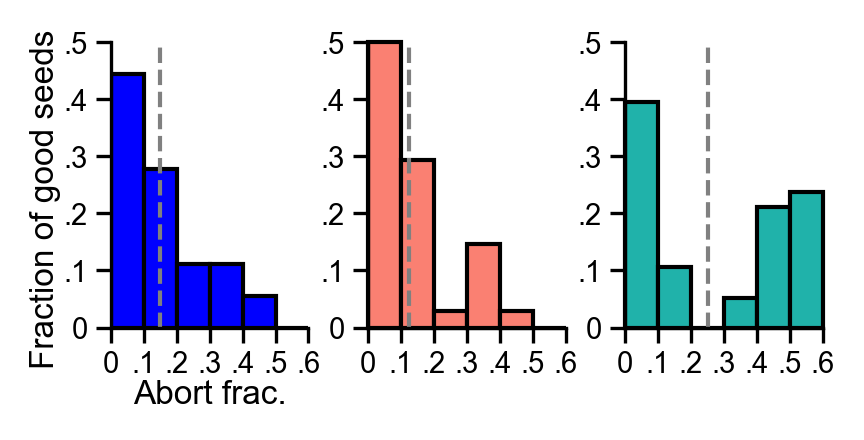

In [13]:
width = 2.7; height = 1.3

yticks = np.around(np.linspace(0, 0.5, 6), 1)
xticks = np.around(np.linspace(0, 0.6, 7), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(131)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Abort frac.', fontsize=fontsize + 1)
ax.set_ylabel('Fraction of good seeds', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.18)
ax.yaxis.set_label_coords(-0.25, 0.45)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

bins = np.linspace(0, 0.6, 7)
mask = actorholistic_agents_reward_rate[:, 99] > 0.6
data1 = actorholistic_agents_skip_frac[mask, 99]
weights = np.ones_like(data1) / len(data1)
ax.hist(data1, weights=weights, bins=bins, alpha=1, histtype='bar', color=holistic_c, edgecolor='k', lw=lw)
ax.plot([data1.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(132)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

mask = actornovalue_agents_reward_rate[:, -1] > 0.6
data2 = actornovalue_agents_skip_frac[mask, -1]
weights = np.ones_like(data2) / len(data2)
ax.hist(data2, weights=weights, bins=bins, alpha=1, histtype='bar', color=withoutvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data2.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(133)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

mask = actorvalue_agents_reward_rate[:, -1] > 0.6
data3 = actorvalue_agents_skip_frac[mask, -1]
weights = np.ones_like(data3) / len(data3)
ax.hist(data3, weights=weights, bins=bins, alpha=1, histtype='bar', color=withvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data3.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')


#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[0.17, 0.5], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.1, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='seeds_dist_abort'), orientation='portrait', format='pdf', transparent=True)

## S3B

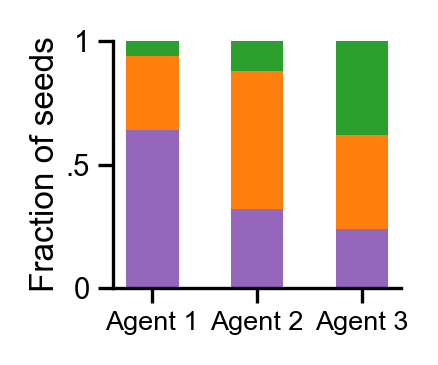

In [14]:
width = 1.35; height = 1.1

yticks = np.linspace(0, 1, 3)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Fraction of seeds', fontsize=fontsize + 1)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.18, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

denominator = np.array([len(actorholistic_agents_reward_rate), len(actornovalue_agents_reward_rate), 
                        len(actorvalue_agents_reward_rate)])
species = ("Agent 1", "Agent 2", "Agent 3")
weight_counts = {
    "bad seeds": np.array([(actorholistic_agents_reward_rate[:, 99] <= 0.6).sum(),
                              (actornovalue_agents_reward_rate[:, -1] <= 0.6).sum(), 
                              (actorvalue_agents_reward_rate[:, -1] <= 0.6).sum()]) / denominator,
    "abort frac.$<=0.3$": np.array([((actorholistic_agents_reward_rate[:, 99] > 0.6) 
                                 & (actorholistic_agents_skip_frac[:, 99] <= 0.3)).sum(),
                                   ((actornovalue_agents_reward_rate[:, -1] > 0.6) 
                                 & (actornovalue_agents_skip_frac[:, -1] <= 0.3)).sum(), 
                                ((actorvalue_agents_reward_rate[:, -1] > 0.6)
                                 & (actorvalue_agents_skip_frac[:, -1] <= 0.3)).sum()]) / denominator,
    "abort frac.$>0.3$": np.array([((actorholistic_agents_reward_rate[:, 99] > 0.6) 
                              & (actorholistic_agents_skip_frac[:, 99] > 0.3)).sum(), 
                                ((actornovalue_agents_reward_rate[:, -1] > 0.6) 
                              & (actornovalue_agents_skip_frac[:, -1] > 0.3)).sum(), 
                             ((actorvalue_agents_reward_rate[:, -1] > 0.6)
                              & (actorvalue_agents_skip_frac[:, -1] > 0.3)).sum()]) / denominator
}
barwidth = 0.5

bottom = np.zeros(3)
for (boolean, weight_count), c in zip(weight_counts.items(), ['C4', 'C1', 'C2']):
    p = ax.bar(species, weight_count, barwidth, label=boolean, bottom=bottom, color=c)
    bottom += weight_count
    
plt.xticks(fontsize=fontsize-0.5)

#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[1, 0], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='proportion_seeds'), orientation='portrait', format='pdf', transparent=True)

## S3A

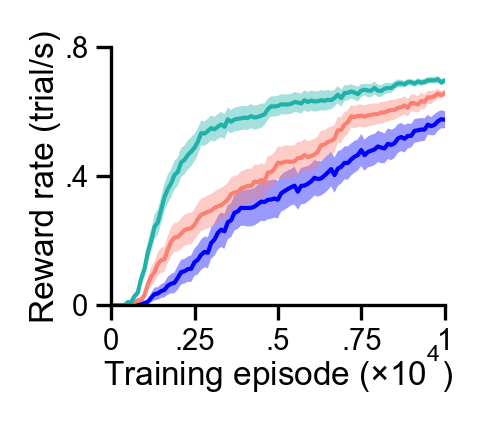

In [15]:
okseed_mask_value = actorvalue_agents_reward_rate[:, -1] > 0.2
okseed_mask_novalue = actornovalue_agents_reward_rate[:, -1] > 0.2
okseed_mask_holistic = actorholistic_agents_reward_rate[:, 99] > 0.2
okseeds_actorvalue = seeds_actorvalue[okseed_mask_value]
okseeds_actornovalue = seeds_actornovalue[okseed_mask_novalue]
okseeds_actorholistic = seeds_actorholistic[okseed_mask_holistic]

mean_reward_rate_ok = [actorholistic_agents_reward_rate[okseed_mask_holistic, :].mean(axis=0),
                    actornovalue_agents_reward_rate[okseed_mask_novalue, :].mean(axis=0),
                    actorvalue_agents_reward_rate[okseed_mask_value, :].mean(axis=0)]
sem_reward_rate_ok = [sem(actorholistic_agents_reward_rate[okseed_mask_holistic, :], axis=0),
                   sem(actornovalue_agents_reward_rate[okseed_mask_novalue, :], axis=0),
                   sem(actorvalue_agents_reward_rate[okseed_mask_value, :], axis=0)]
mean_trial_dur_ok = [actorholistic_agents_trial_dur[okseed_mask_holistic, :].mean(axis=0),
                  actornovalue_agents_trial_dur[okseed_mask_novalue, :].mean(axis=0), 
                  actorvalue_agents_trial_dur[okseed_mask_value, :].mean(axis=0)]
sem_trial_dur_ok = [sem(actorholistic_agents_trial_dur[okseed_mask_holistic, :], axis=0), 
                 sem(actornovalue_agents_trial_dur[okseed_mask_novalue, :], axis=0), 
                 sem(actorvalue_agents_trial_dur[okseed_mask_value, :], axis=0)]

width = 1.5; height = 1.3
MAX_TRAINING_T = 10000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.8, 3), 2)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training episode ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

for ymean, ysem, color, label, xdata in zip(mean_reward_rate_ok, sem_reward_rate_ok,
                                            [holistic_c, withoutvalue_c, withvalue_c],
                                            ['Agent 1', 'Agent 2', 'Agent 3'],
                                            [actorholistic_agents_training_progress[0].episode.values,
                                             actornovalue_agents_training_progress[0].episode.values,
                                             actorvalue_agents_training_progress[0].episode.values]):
    ax.plot(xdata, ymean, lw=lw, clip_on=True, c=color, label=label)
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=color, alpha=0.4)

#ax.legend(fontsize=fontsize, frameon=False, loc=[0.45, 0], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_training_scratch_exclude'), orientation='portrait', format='pdf', transparent=True)

## S3F

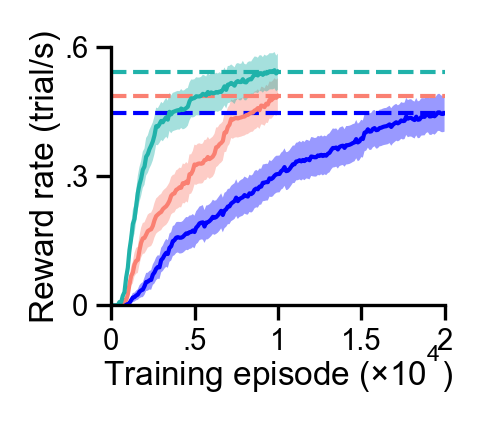

In [16]:
width = 1.5; height = 1.3
MAX_TRAINING_T = 20000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.6, 3), 2)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training episode ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

for ymean, ysem, color, label, xdata in zip(mean_reward_rate, sem_reward_rate,
                                            [holistic_c, withoutvalue_c, withvalue_c],
                                            ['Agent 1', 'Agent 2', 'Agent 3'],
                                            [actorholistic_agents_training_progress[0].episode.values,
                                             actornovalue_agents_training_progress[0].episode.values,
                                             actorvalue_agents_training_progress[0].episode.values]):
    ax.plot(xdata, ymean, lw=lw, clip_on=True, c=color, label=label)
    ax.plot(ax.get_xlim(), [ymean[-1]] * 2, c=color, lw=lw, ls='--')
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=color, alpha=0.4)

#ax.legend(fontsize=fontsize, frameon=False, loc=[0.28, 1], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_training_scratch_longtime'), orientation='portrait', format='pdf', transparent=True)

## S3H

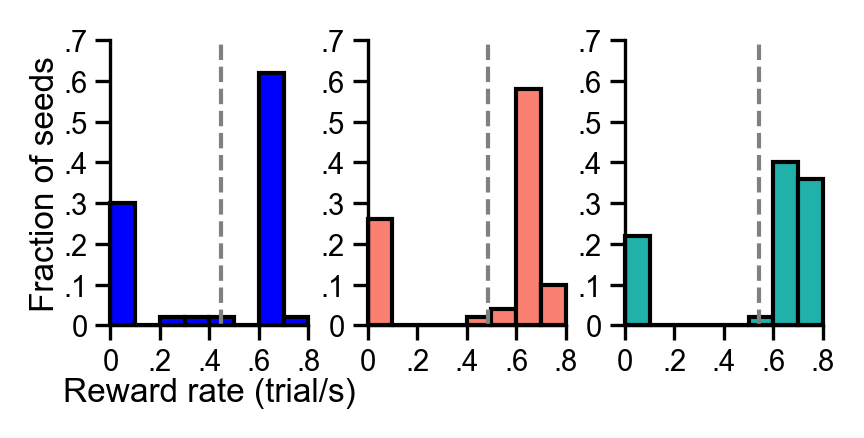

In [17]:
width = 2.7; height = 1.3

yticks = np.around(np.linspace(0, 0.7, 8), 1)
xticks = [0, 0.2, 0.4, 0.6, 0.8]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(131)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_ylabel('Fraction of seeds', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.18)
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

bins = np.linspace(0, 0.8, 9)
data = actorholistic_agents_reward_rate[:, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=holistic_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(132)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = actornovalue_agents_reward_rate[:, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withoutvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(133)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = actorvalue_agents_reward_rate[:, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')


#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[0.17, 0.5], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.1, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='seeds_dist_rate_longtime'), orientation='portrait', format='pdf', transparent=True)

## S3I

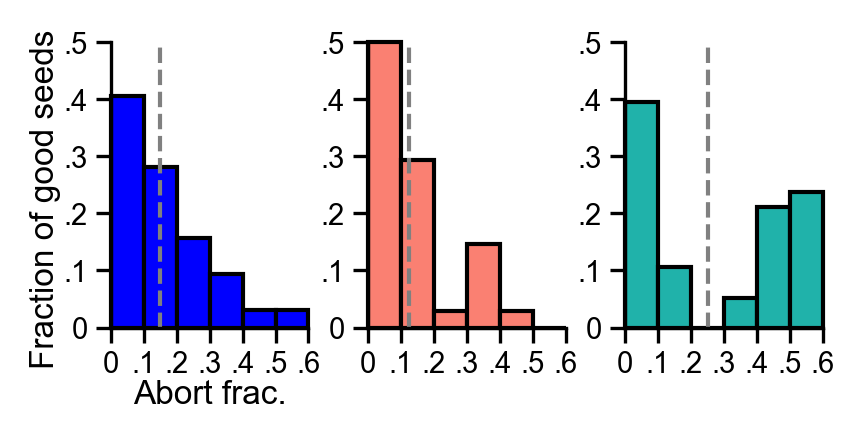

In [18]:
width = 2.7; height = 1.3

yticks = np.around(np.linspace(0, 0.5, 6), 1)
xticks = np.around(np.linspace(0, 0.6, 7), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(131)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Abort frac.', fontsize=fontsize + 1)
ax.set_ylabel('Fraction of good seeds', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.18)
ax.yaxis.set_label_coords(-0.25, 0.45)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

bins = np.linspace(0, 0.6, 7)
mask = actorholistic_agents_reward_rate[:, -1] > 0.6
data = actorholistic_agents_skip_frac[mask, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, 
        histtype='bar', color=holistic_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(132)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

mask = actornovalue_agents_reward_rate[:, -1] > 0.6
data = actornovalue_agents_skip_frac[mask, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, 
        histtype='bar', color=withoutvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')

ax = fig.add_subplot(133)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

mask = actorvalue_agents_reward_rate[:, -1] > 0.6
data = actorvalue_agents_skip_frac[mask, -1]
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, 
        histtype='bar', color=withvalue_c, edgecolor='k', clip_on=False, lw=lw)
ax.plot([data.mean()] * 2, ax.get_ylim(), c='gray', lw=lw, ls='--')


#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[0.17, 0.5], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.1, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='seeds_dist_abort_longtime'), orientation='portrait', format='pdf', transparent=True)

## S3G

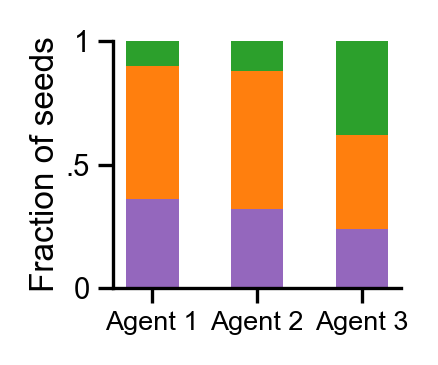

In [19]:
width = 1.35; height = 1.1

yticks = np.linspace(0, 1, 3)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Fraction of seeds', fontsize=fontsize + 1)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.18, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

denominator = np.array([len(actorholistic_agents_reward_rate), len(actornovalue_agents_reward_rate), 
                        len(actorvalue_agents_reward_rate)])
species = ("Agent 1", "Agent 2", "Agent 3")
weight_counts = {
    "bad seeds": np.array([(actorholistic_agents_reward_rate[:, -1] <= 0.6).sum(),
                              (actornovalue_agents_reward_rate[:, -1] <= 0.6).sum(), 
                              (actorvalue_agents_reward_rate[:, -1] <= 0.6).sum()]) / denominator,
    "abort frac.$<=0.3$": np.array([((actorholistic_agents_reward_rate[:, -1] > 0.6) 
                                 & (actorholistic_agents_skip_frac[:, -1] <= 0.3)).sum(),
                                   ((actornovalue_agents_reward_rate[:, -1] > 0.6) 
                                 & (actornovalue_agents_skip_frac[:, -1] <= 0.3)).sum(), 
                                ((actorvalue_agents_reward_rate[:, -1] > 0.6)
                                 & (actorvalue_agents_skip_frac[:, -1] <= 0.3)).sum()]) / denominator,
    "abort frac.$>0.3$": np.array([((actorholistic_agents_reward_rate[:, -1] > 0.6) 
                              & (actorholistic_agents_skip_frac[:, -1] > 0.3)).sum(), 
                                ((actornovalue_agents_reward_rate[:, -1] > 0.6) 
                              & (actornovalue_agents_skip_frac[:, -1] > 0.3)).sum(), 
                             ((actorvalue_agents_reward_rate[:, -1] > 0.6)
                              & (actorvalue_agents_skip_frac[:, -1] > 0.3)).sum()]) / denominator
}
barwidth = 0.5

bottom = np.zeros(3)
for (boolean, weight_count), c in zip(weight_counts.items(), ['C4', 'C1', 'C2']):
    p = ax.bar(species, weight_count, barwidth, label=boolean, bottom=bottom, color=c)
    bottom += weight_count
    
plt.xticks(fontsize=fontsize-0.5)

#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[1, 0], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='proportion_seeds_longtime'), orientation='portrait', format='pdf', transparent=True)

# Run agent

In [20]:
from Agent_LSTM import *
from Environment import Env

In [21]:
reset_seeds(0)
env = Env(arg)
target_positions = []

for _ in range(2000):
    __ = env.reset()
    target_positions.append(env.target_position)

In [22]:
def LSTM_agent_simulation(agent):
    reset_seeds(0)
    env = Env(arg)

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []
    skipped = []

    for target_position in target_positions:
        cross_start_threshold = False
        x = env.reset(target_position=target_position)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1),
                           torch.zeros(1, 1, 1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1),
                                    torch.ones(1, 1, 1) * (t + 1)
                                   ], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)

            true_states.append(x)
            states.append(state)
            actions.append(action)
            
            if is_stop and cross_start_threshold:
                break
            
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

        # Trial end
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))

        state_.append(torch.cat(states))
        
        action_.append(torch.cat(actions))
        action_v_temp, action_w_temp = torch.chunk(torch.cat(actions).squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        skipped.append(pos_r_end[-1] < target_r[-1] * 0.3)
        
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, state=state_, action=action_,
                                 skipped=skipped))

In [23]:
okseed_mask_value = actorvalue_agents_reward_rate[:, -1] > 0.2
okseed_mask_novalue = actornovalue_agents_reward_rate[:, -1] > 0.2
okseed_mask_holistic = actorholistic_agents_reward_rate[:, 99] > 0.2
okseed_mask_holisticLong = actorholistic_agents_reward_rate[:, -1] > 0.2
okseeds_actorvalue = seeds_actorvalue[okseed_mask_value]
okseeds_actornovalue = seeds_actornovalue[okseed_mask_novalue]
okseeds_actorholistic = seeds_actorholistic[okseed_mask_holistic]
okseeds_actorholisticLong = seeds_actorholistic[okseed_mask_holisticLong]

goodseed_mask_value = actorvalue_agents_reward_rate[:, -1] > 0.6
goodseed_mask_novalue = actornovalue_agents_reward_rate[:, -1] > 0.6
goodseed_mask_holistic = actorholistic_agents_reward_rate[:, 99] > 0.6
goodseed_mask_holisticLong = actorholistic_agents_reward_rate[:, -1] > 0.6
goodmask_fromok_value = np.isin(np.where(okseed_mask_value)[0], np.where(goodseed_mask_value)[0])
goodmask_fromok_novalue = np.isin(np.where(okseed_mask_novalue)[0], np.where(goodseed_mask_novalue)[0])
goodmask_fromok_holistic = np.isin(np.where(okseed_mask_holistic)[0], np.where(goodseed_mask_holistic)[0])
goodmask_fromok_holisticLong = np.isin(np.where(okseed_mask_holisticLong)[0], np.where(goodseed_mask_holisticLong)[0])

In [871]:
#run agents
'''
epi = 9999
actorvalue_data = []; actornovalue_data = []; actorholistic_data = []; actorholisticLong_data = []
actorvalue_agents = []; actornovalue_agents = []; actorholistic_agents = []; actorholisticLong_agents = []
for seed in okseeds_actorvalue:
    actorvalue_agent = Agent(arg, Actor, Critic)
    actorvalue_agent.data_path = actorvalue_agents_path / f'seed{seed}'
    actorvalue_agent.load(list((actorvalue_agents_path / f'seed{seed}').glob('*.csv'))[0].stem + f'-{epi}', 
                          load_memory=False, load_optimzer=False)
    df = LSTM_agent_simulation(actorvalue_agent)
    actorvalue_data.append(df)
    actorvalue_agents.append(actorvalue_agent)
    
for seed in okseeds_actornovalue:
    actornovalue_agent = Agent(arg, Actor_novalue, Critic)
    actornovalue_agent.data_path = actornovalue_agents_path / f'seed{seed}'
    actornovalue_agent.load(list((actornovalue_agents_path / f'seed{seed}').glob('*.csv'))[0].stem + f'-{epi}', 
                            load_memory=False, load_optimzer=False)
    df = LSTM_agent_simulation(actornovalue_agent)
    actornovalue_data.append(df)
    actornovalue_agents.append(actornovalue_agent)

for seed in okseeds_actorholistic:
    actorholistic_agent = Agent(arg, Actor_holistic, Critic)
    actorholistic_agent.data_path = actorholistic_agents_path / f'seed{seed}'
    actorholistic_agent.load(list((actorholistic_agents_path / f'seed{seed}').glob('*.csv'))[0].stem + f'-{epi}', 
                            load_memory=False, load_optimzer=False)
    df = LSTM_agent_simulation(actorholistic_agent)
    actorholistic_data.append(df)
    actorholistic_agents.append(actorholistic_agent)
    
for seed in okseeds_actorholisticLong:
    actorholistic_agent = Agent(arg, Actor_holistic, Critic)
    actorholistic_agent.data_path = actorholistic_agents_path / f'seed{seed}'
    actorholistic_agent.load(list((actorholistic_agents_path / f'seed{seed}').glob('*.csv'))[0].stem + f'-{epi+10000}', 
                            load_memory=False, load_optimzer=False)
    df = LSTM_agent_simulation(actorholistic_agent)
    actorholisticLong_data.append(df)
    actorholisticLong_agents.append(actorholistic_agent)
'''

In [908]:
#store data
'''
with open(analysis_data_path / 'actorvalue_data.pkl', 'wb') as file:
    pickle.dump(actorvalue_data, file)
    
with open(analysis_data_path / 'actornovalue_data.pkl', 'wb') as file:
    pickle.dump(actornovalue_data, file)
    
with open(analysis_data_path / 'actorholistic_data.pkl', 'wb') as file:
    pickle.dump(actorholistic_data, file)
    
with open(analysis_data_path / 'actorholisticLong_data.pkl', 'wb') as file:
    pickle.dump(actorholisticLong_data, file)

with open(analysis_data_path / 'actorvalue_agents.pkl', 'wb') as file:
    pickle.dump(actorvalue_agents, file)
    
with open(analysis_data_path / 'actornovalue_agents.pkl', 'wb') as file:
    pickle.dump(actornovalue_agents, file)
    
with open(analysis_data_path / 'actorholistic_agents.pkl', 'wb') as file:
    pickle.dump(actorholistic_agents, file)
    
with open(analysis_data_path / 'actorholisticLong_agents.pkl', 'wb') as file:
    pickle.dump(actorholisticLong_agents, file)
'''

In [26]:
#load data
with open(analysis_data_path / 'actorvalue_data.pkl', 'rb') as file:
    actorvalue_data = pickle.load(file)
    
with open(analysis_data_path / 'actornovalue_data.pkl', 'rb') as file:
    actornovalue_data = pickle.load(file)
    
with open(analysis_data_path / 'actorholistic_data.pkl', 'rb') as file:
    actorholistic_data = pickle.load(file)
    
with open(analysis_data_path / 'actorholisticLong_data.pkl', 'rb') as file:
    actorholisticLong_data = pickle.load(file)
    
with open(analysis_data_path / 'actorvalue_agents.pkl', 'rb') as file:
    actorvalue_agents = pickle.load(file)
    
with open(analysis_data_path / 'actornovalue_agents.pkl', 'rb') as file:
    actornovalue_agents = pickle.load(file)
    
with open(analysis_data_path / 'actorholistic_agents.pkl', 'rb') as file:
    actorholistic_agents = pickle.load(file)
    
with open(analysis_data_path / 'actorholisticLong_agents.pkl', 'rb') as file:
    actorholisticLong_agents = pickle.load(file)

## 2G

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


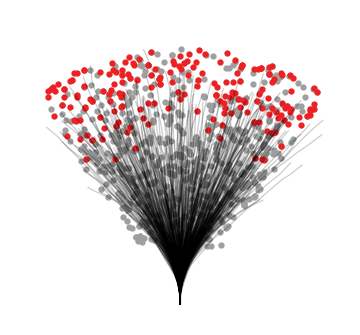

In [27]:
# agent 3
dfs = pd.concat([df for idx, df in enumerate(actorvalue_data) if goodmask_fromok_value[idx]], ignore_index=True)
df = dfs.sample(800, random_state=37)
fig = plt.figure(figsize=(1., 1.), dpi=300)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

for _, trial in df.iterrows():
    ax.plot(trial.pos_x, trial.pos_y, c='k', lw=0.3, ls='-', alpha=0.2)

skipped_idexes = df.skipped.values
skipped_idexes = skipped_idexes
for label, mask, c in zip(['Attempted', 'Aborted'], [~skipped_idexes, skipped_idexes], 
                          [attempt_c, abort_c]):
    ax.scatter(*df.loc[mask, ['target_x', 'target_y']].values.T, 
               c=c, marker='o', s=1, lw=0.5)

ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0], 
          handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0)

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='traj_dist_value_concat'), orientation='portrait', format='pdf', transparent=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


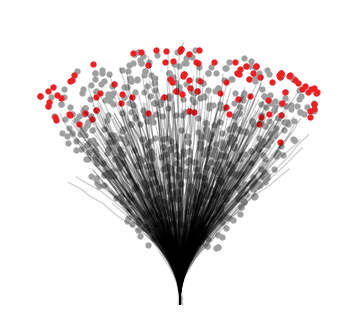

In [28]:
# agent 2
dfs = pd.concat([df for idx, df in enumerate(actornovalue_data) if goodmask_fromok_novalue[idx]], ignore_index=True)
df = dfs.sample(800, random_state=1)
fig = plt.figure(figsize=(1., 1.), dpi=300)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

#ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10, 
#        c='k', ls=(0, (1, 1)), lw=lw)
for _, trial in df.iterrows():
    ax.plot(trial.pos_x, trial.pos_y, c='k', lw=0.3, ls='-', alpha=0.2)

skipped_idexes = df.skipped.values
skipped_idexes = skipped_idexes
for label, mask, c in zip(['Attempted', 'Aborted'], [~skipped_idexes, skipped_idexes], 
                          [attempt_c, abort_c]):
    ax.scatter(*df.loc[mask, ['target_x', 'target_y']].values.T, 
               c=c, marker='o', s=1, lw=0.5)


#x_temp = np.linspace(-235, 235)
#ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
#ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
#ax.text(130, 150, s=r'400 cm', fontsize=fontsize)

#ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
#ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
#ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
#ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)

#ax.text(-210, 30, s="Modular agent's\ntrajectories", fontsize=fontsize - 0.5, c=withvalue_c)

ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0], 
          handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0)

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='traj_dist_novalue_concat'), orientation='portrait', format='pdf', transparent=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


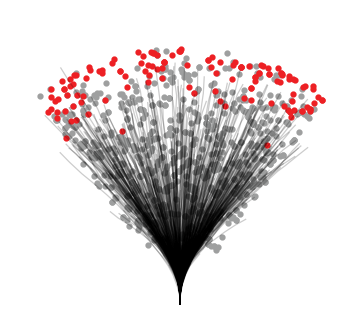

In [29]:
# agent 1
dfs = pd.concat([df for idx, df in enumerate(actorholistic_data) if goodmask_fromok_holistic[idx]], ignore_index=True)
df = dfs.sample(800, random_state=1)
fig = plt.figure(figsize=(1., 1.), dpi=300)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

#ax.plot(np.linspace(0, 230 + 7), np.tan(np.deg2rad(55)) * np.linspace(0, 230 + 7) - 10, 
#        c='k', ls=(0, (1, 1)), lw=lw)
for _, trial in df.iterrows():
    ax.plot(trial.pos_x, trial.pos_y, c='k', lw=0.3, ls='-', alpha=0.2)

skipped_idexes = df.skipped.values
skipped_idexes = skipped_idexes
for label, mask, c in zip(['Attempted', 'Aborted'], [~skipped_idexes, skipped_idexes], 
                          [attempt_c, abort_c]):
    ax.scatter(*df.loc[mask, ['target_x', 'target_y']].values.T, 
               c=c, marker='o', s=1, lw=0.5)


#x_temp = np.linspace(-235, 235)
#ax.plot(x_temp, np.sqrt(420**2 - x_temp**2), c='k', ls=(0, (1, 1)), lw=lw)
#ax.text(-10, 425, s=r'70$\degree$', fontsize=fontsize)
#ax.text(130, 150, s=r'400 cm', fontsize=fontsize)

#ax.plot(np.linspace(-230, -130), np.linspace(0, 0), c='k', lw=lw)
#ax.plot(np.linspace(-230, -230), np.linspace(0, 100), c='k', lw=lw)
#ax.text(-230, 100, s=r'100 cm', fontsize=fontsize)
#ax.text(-130, 0, s=r'100 cm', fontsize=fontsize)

#ax.text(-210, 30, s="Modular agent's\ntrajectories", fontsize=fontsize - 0.5, c=withvalue_c)

ax.legend(fontsize=fontsize, frameon=False, loc=[0.56, 0.0], 
          handletextpad=-0.5, labelspacing=0, ncol=1, columnspacing=1)

fig.tight_layout(pad=0)

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='traj_dist_holistic_concat'), orientation='portrait', format='pdf', transparent=True)

## 2H

In [30]:
bin_edges = np.arange(100, 401, 10)
skipped_frac_bybin_value = []
for df in actorvalue_data:
    skipped_frac_bybin = []
    for edge_idx in range(bin_edges.size - 1):
        left_edge = bin_edges[edge_idx]
        right_edge = bin_edges[edge_idx + 1]
        trials_inbin = df.skipped[(df.target_r >= left_edge) & (df.target_r < right_edge)]
        skipped_frac_bybin.append(trials_inbin.sum() / len(trials_inbin))
    skipped_frac_bybin_value.append(skipped_frac_bybin)

In [31]:
skipped_frac_bybin_novalue = []
for df in actornovalue_data:
    skipped_frac_bybin = []
    for edge_idx in range(bin_edges.size - 1):
        left_edge = bin_edges[edge_idx]
        right_edge = bin_edges[edge_idx + 1]
        trials_inbin = df.skipped[(df.target_r >= left_edge) & (df.target_r < right_edge)]
        skipped_frac_bybin.append(trials_inbin.sum() / len(trials_inbin))
    skipped_frac_bybin_novalue.append(skipped_frac_bybin)

In [32]:
skipped_frac_bybin_holisticLong = []
for df in actorholisticLong_data:
    skipped_frac_bybin = []
    for edge_idx in range(bin_edges.size - 1):
        left_edge = bin_edges[edge_idx]
        right_edge = bin_edges[edge_idx + 1]
        trials_inbin = df.skipped[(df.target_r >= left_edge) & (df.target_r < right_edge)]
        skipped_frac_bybin.append(trials_inbin.sum() / len(trials_inbin))
    skipped_frac_bybin_holisticLong.append(skipped_frac_bybin)

In [33]:
ymean_value = np.mean(skipped_frac_bybin_value, axis=0)
ysem_value = sem(np.array(skipped_frac_bybin_value), axis=0)
ymean_novalue = np.mean(skipped_frac_bybin_novalue, axis=0)
ysem_novalue = sem(np.array(skipped_frac_bybin_novalue), axis=0)
ymean_holisticLong = np.mean(skipped_frac_bybin_holisticLong, axis=0)
ysem_holisticLong = sem(np.array(skipped_frac_bybin_holisticLong), axis=0)

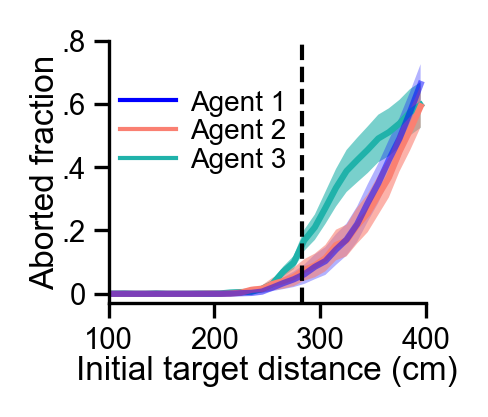

In [34]:
width = 1.5; height = 1.3

yticks = np.around(np.linspace(0, 0.8, 5), 1)
xticks = np.arange(100, 401, 100)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Initial target distance (cm)', fontsize=fontsize + 1)
ax.set_ylabel('Aborted fraction', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0] - 0.03, yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = (bin_edges[:-1] + bin_edges[1:]) / 2    
    
ax.plot(xdata, ymean_value, lw=lw*1.5, clip_on=False, c=withvalue_c, alpha=1)
ax.plot(xdata, ymean_novalue, lw=lw*1.5, clip_on=False, c=withoutvalue_c, alpha=1)
ax.plot(xdata, ymean_holisticLong, lw=lw*1.5, clip_on=False, c=holistic_c, alpha=0.5)
ax.fill_between(xdata, ymean_value - ysem_value, ymean_value + ysem_value,
                edgecolor='None', facecolor=withvalue_c, alpha=0.6, clip_on=False) 
ax.fill_between(xdata, ymean_holisticLong - ysem_holisticLong, ymean_holisticLong + ysem_holisticLong,
                edgecolor='None', facecolor=holistic_c, alpha=0.3, clip_on=False) 
ax.fill_between(xdata, ymean_novalue - ysem_novalue, ymean_novalue + ysem_novalue,
                edgecolor='None', facecolor=withoutvalue_c, alpha=0.6, clip_on=False) 


ax.plot([], [], lw=lw, clip_on=False, c=holistic_c, alpha=1, label='Agent 1')
ax.plot([], [], lw=lw, clip_on=False, c=withoutvalue_c, alpha=1, label='Agent 2')
ax.plot([], [], lw=lw, clip_on=False, c=withvalue_c, alpha=1, label='Agent 3')

ax.plot([200 * np.sqrt(2)] * 2, ax.get_ylim(), lw=lw, c='k', ls='--', clip_on=False)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

ax.legend(fontsize=fontsize - 0.3, frameon=False, loc=[0, 0.45], 
          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='skipped_fraction_dist_fromscratch'), orientation='portrait', format='pdf', transparent=True)

## S3E 

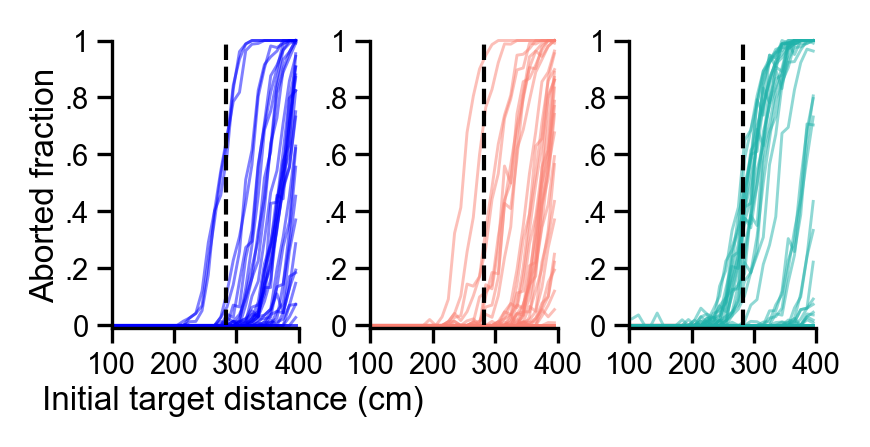

In [35]:
width = 2.7; height = 1.3

yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.arange(100, 401, 100)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(131)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Initial target distance (cm)', fontsize=fontsize + 1)
ax.set_ylabel('Aborted fraction', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0] - 0.01, yticks[-1])
ax.xaxis.set_label_coords(0.65, -0.2)
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = (bin_edges[:-1] + bin_edges[1:]) / 2    

for v in skipped_frac_bybin_holisticLong:
    ax.plot(xdata, v, lw=lw*0.7, clip_on=False, c=holistic_c, alpha=0.5)

#xdata = np.linspace(100, 400, 1000)
#ydata = np.zeros(xdata.size); ydata[xdata > 200 * np.sqrt(2)] = 1
#ax.plot(xdata, ydata, lw=lw, c='k', ls='--', clip_on=False)
ax.plot([200 * np.sqrt(2)] * 2, [0, 1], lw=lw, c='k', ls='--', clip_on=False)

ax = fig.add_subplot(132)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0] - 0.01, yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2) 

for v in skipped_frac_bybin_novalue:
    ax.plot(xdata, v, lw=lw*0.7, clip_on=False, c=withoutvalue_c, alpha=0.5)

ax.plot([200 * np.sqrt(2)] * 2, [0, 1], lw=lw, c='k', ls='--', clip_on=False)

ax = fig.add_subplot(133)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0] - 0.01, yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)    

for v in skipped_frac_bybin_value:
    ax.plot(xdata, v, lw=lw*0.7, clip_on=False, c=withvalue_c, alpha=0.5)

ax.plot([200 * np.sqrt(2)] * 2, [0, 1], lw=lw, c='k', ls='--', clip_on=False)


fig.tight_layout(pad=0, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='skipped_fraction_dist_fromscratch_allseeds'), orientation='portrait', format='pdf', transparent=True)

## S4A

In [36]:
b__ = []; av__ = []; aw__ = []; x__ = []; rewarded_frac = []; skipped_frac = []; reward_rate = []
for df, agent in zip(actorholisticLong_data, actorholisticLong_agents):
    actor = agent.actor
    b_ = []; av_ = [];aw_ = []; x_ = []
    for trial in df.itertuples():
        b_.append(trial.relative_radius)
        x = trial.state[..., :-1]
        with torch.no_grad():
            x, _ = actor.rnn(x)
            a = actor.l1(x)
            x_.append(x.squeeze().numpy())
            av_.append(a.squeeze()[:, 0].numpy())
            aw_.append(a.squeeze()[:, 1].numpy())
            
    b__.append(np.hstack(b_)); av__.append(np.hstack(av_)); aw__.append(np.hstack(aw_)); x__.append(np.concatenate(x_))
    rewarded_frac.append(df.rewarded.sum() / len(df))
    reward_rate.append(df.rewarded.sum() / (np.hstack(df.pos_x).size - len(df)) / arg.DT)
    skipped_frac.append(df.skipped.sum() / len(df))
    
rewarded_frac = np.array(rewarded_frac); skipped_frac = np.array(skipped_frac); reward_rate = np.array(reward_rate)

In [37]:
def get_tuning_corrs(b__, av__, aw__, x__, corr_thre=0.5):
    count_b_cav_tune = []; count_b_caw_tune = []
    count_av_cb_tune = []; count_aw_cb_tune = []
    count_b_av_tune = []; count_b_aw_tune = []
    for b, av, aw, x in zip(b__, av__, aw__, x__):
        corrxb_av = [];corrxb_aw = []
        corrxav_b = []; corrxaw_b = []
        
        # av
        rbav = np.corrcoef(av, b)[0, 1]
        for neural_idx in range(x.shape[1]):
            rxb = np.corrcoef(x[:, neural_idx], b)[0, 1]
            rxav = np.corrcoef(x[:, neural_idx], av)[0, 1]
            rxb_av = (rxb - rxav * rbav) / np.sqrt((1-rxav**2) * (1-rbav**2))
            #corrxb_av.append(rxb_av)
            corrxb_av.append(rxb)
            rxav_b = (rxav - rxb * rbav) / np.sqrt((1-rxb**2) * (1-rbav**2))
            #corrxav_b.append(rxav_b)
            corrxav_b.append(rxav)
            
        # aw
        rbaw = np.corrcoef(aw, b)[0, 1]
        for neural_idx in range(x.shape[1]):
            rxb = np.corrcoef(x[:, neural_idx], b)[0, 1]
            rxaw = np.corrcoef(x[:, neural_idx], aw)[0, 1]
            rxb_aw = (rxb - rxaw * rbaw) / np.sqrt((1-rxaw**2) * (1-rbaw**2))
            #corrxb_aw.append(rxb_aw)
            corrxb_aw.append(rxb)
            rxaw_b = (rxaw - rxb * rbaw) / np.sqrt((1-rxb**2) * (1-rbaw**2))
            #corrxaw_b.append(rxaw_b)
            corrxaw_b.append(rxaw)
            
        corrxb_av = np.array(corrxb_av); corrxb_aw = np.array(corrxb_aw)
        corrxav_b = np.array(corrxav_b); corrxaw_b = np.array(corrxaw_b)

        tuneb_av_idx = np.where(abs(corrxb_av) > corr_thre)[0]
        tuneb_aw_idx = np.where(abs(corrxb_aw) > corr_thre)[0]
        tuneav_b_idx = np.where(abs(corrxav_b) > corr_thre)[0]
        tuneaw_b_idx = np.where(abs(corrxaw_b) > corr_thre)[0]

        count_b_cav_tune.append(tuneb_av_idx.size); count_b_caw_tune.append(tuneb_aw_idx.size)
        count_av_cb_tune.append(tuneav_b_idx.size); count_aw_cb_tune.append(tuneaw_b_idx.size);
        #count_singletune.append(np.unique(np.hstack([tunebidx, tuneaidx])).size)
        #count_b_av_tune.append(np.intersect1d(tuneb_av_idx, tuneav_b_idx).size)
        #count_b_av_tune.append(np.intersect1d(np.unique(np.hstack([tuneav_b_idx, tuneaw_b_idx])), tuneb_av_idx).size)
        count_b_av_tune.append(np.intersect1d(np.intersect1d(tuneav_b_idx, tuneaw_b_idx), tuneb_av_idx).size)
        count_b_aw_tune.append(np.intersect1d(tuneb_aw_idx, tuneaw_b_idx).size)

    count_b_cav_tune = np.array(count_b_cav_tune); count_b_caw_tune = np.array(count_b_caw_tune)
    count_av_cb_tune = np.array(count_av_cb_tune); count_aw_cb_tune = np.array(count_aw_cb_tune)
    count_b_av_tune = np.array(count_b_av_tune); count_b_aw_tune = np.array(count_b_aw_tune)
    
    return count_b_cav_tune, count_b_caw_tune, count_av_cb_tune, count_aw_cb_tune, count_b_av_tune, count_b_aw_tune

In [38]:
count_b_cav_tune = []; count_b_caw_tune = []
count_av_cb_tune = []; count_aw_cb_tune = []
count_b_av_tune = []; count_b_aw_tune = []

corr_countb_cav_reward = []; corr_countb_caw_reward = []
corr_countav_cb_reward = []; corr_countaw_cb_reward = []
corr_countb_av_reward = []; corr_countb_aw_reward = []

p_countb_cav_reward = []; p_countb_caw_reward = []
p_countav_cb_reward = []; p_countaw_cb_reward = []
p_countb_av_reward = []; p_countb_aw_reward = []

thresholds = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
for corr_thre in thresholds:
    count_b_cav_tune_, count_b_caw_tune_, count_av_cb_tune_, \
    count_aw_cb_tune_, count_b_av_tune_, count_b_aw_tune_ = get_tuning_corrs(b__, av__, aw__, x__, corr_thre=corr_thre)
    
    count_b_cav_tune.append(count_b_cav_tune_)
    count_b_caw_tune.append(count_b_caw_tune_)
    count_av_cb_tune.append(count_av_cb_tune_)
    count_aw_cb_tune.append(count_aw_cb_tune_)
    count_b_av_tune.append(count_b_av_tune_)
    count_b_aw_tune.append(count_b_aw_tune_)
    
    #method = PermutationMethod(random_state=0)
    method = None
    r = pearsonr(count_b_cav_tune_, rewarded_frac)
    corr_countb_cav_reward.append(r.statistic)
    p_countb_cav_reward.append(r.pvalue)
    
    r = pearsonr(count_b_caw_tune_, rewarded_frac)
    corr_countb_caw_reward.append(r.statistic)
    p_countb_caw_reward.append(r.pvalue)
    
    r = pearsonr(count_av_cb_tune_, rewarded_frac)
    corr_countav_cb_reward.append(r.statistic)
    p_countav_cb_reward.append(r.pvalue)
    
    r = pearsonr(count_aw_cb_tune_, rewarded_frac)
    corr_countaw_cb_reward.append(r.statistic)
    p_countaw_cb_reward.append(r.pvalue)
    
    r = pearsonr(count_b_av_tune_, rewarded_frac)
    corr_countb_av_reward.append(r.statistic)
    p_countb_av_reward.append(r.pvalue)
    
    r = pearsonr(count_b_aw_tune_, rewarded_frac)
    corr_countb_aw_reward.append(r.statistic)
    p_countb_aw_reward.append(r.pvalue)
    

corr_countb_cav_reward, corr_countb_caw_reward, corr_countav_cb_reward,\
corr_countaw_cb_reward, corr_countb_av_reward, corr_countb_aw_reward = map(np.array, [corr_countb_cav_reward, 
         corr_countb_caw_reward, corr_countav_cb_reward, corr_countaw_cb_reward, corr_countb_av_reward, corr_countb_aw_reward])
p_countb_cav_reward, p_countb_caw_reward, p_countav_cb_reward,\
p_countaw_cb_reward, p_countb_av_reward, p_countb_aw_reward = map(np.array, [p_countb_cav_reward, 
         p_countb_caw_reward, p_countav_cb_reward, p_countaw_cb_reward, p_countb_av_reward, p_countb_aw_reward])

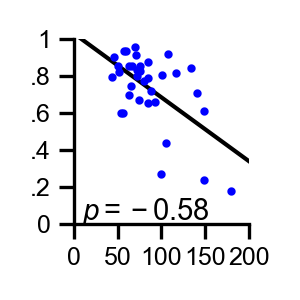

In [39]:
width = 0.8; height = 0.8

yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.arange(0, 201, 50)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize - 1)
plt.yticks(yticks, fontsize=fontsize - 1)
ax.set_xlabel(r'', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = count_av_cb_tune[2]; ydata = rewarded_frac
ax.scatter(xdata, ydata, s=1, c=holistic_c, clip_on=False)
ax.text(10, 0.02, f'$p={np.around(corr_countav_cb_reward[2], 2)}$', fontsize=fontsize)
model = LinearRegression()
model.fit(xdata.reshape(-1, 1), ydata)
xata = np.linspace(*ax.get_xlim())
ax.plot(xata, model.predict(xata.reshape(-1, 1)), lw=lw, c='k', zorder=0, ls='-')

fig.tight_layout(pad=0, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='tuning_vs_reward_av_cb'), orientation='portrait', format='pdf', transparent=True)

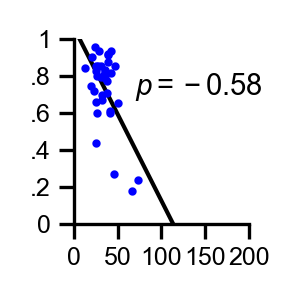

In [40]:
width = 0.8; height = 0.8

yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.arange(0, 201, 50)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize - 1)
plt.yticks(yticks, fontsize=fontsize - 1)
ax.set_xlabel(r'', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = count_aw_cb_tune[2]; ydata = rewarded_frac
ax.scatter(xdata, ydata, s=1, c=holistic_c, clip_on=False)
ax.text(70, 0.7, f'$p={np.around(corr_countaw_cb_reward[2], 2)}$', fontsize=fontsize)
model = LinearRegression()
model.fit(xdata.reshape(-1, 1), ydata)
xata = np.linspace(*ax.get_xlim())
ax.plot(xata, model.predict(xata.reshape(-1, 1)), lw=lw, c='k', zorder=0, ls='-')

fig.tight_layout(pad=0, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='tuning_vs_reward_aw_cb'), orientation='portrait', format='pdf', transparent=True)

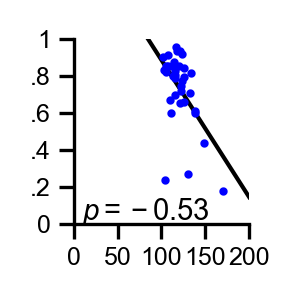

In [41]:
width = 0.8; height = 0.8

yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.arange(0, 201, 50)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize - 1)
plt.yticks(yticks, fontsize=fontsize - 1)
ax.set_xlabel(r'', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = count_b_cav_tune[2]; ydata = rewarded_frac
ax.scatter(xdata, ydata, s=1, c=holistic_c, clip_on=False)
ax.text(10, 0.02, f'$p={np.around(corr_countb_cav_reward[2], 2)}$', fontsize=fontsize)
model = LinearRegression()
model.fit(xdata.reshape(-1, 1), ydata)
xata = np.linspace(*ax.get_xlim())
ax.plot(xata, model.predict(xata.reshape(-1, 1)), lw=lw, c='k', zorder=0, ls='-')

fig.tight_layout(pad=0, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='tuning_vs_reward_b_cav'), orientation='portrait', format='pdf', transparent=True)

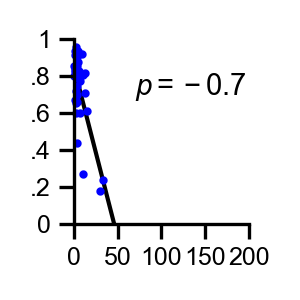

In [42]:
width = 0.8; height = 0.8

yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = np.arange(0, 201, 50)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize - 1)
plt.yticks(yticks, fontsize=fontsize - 1)
ax.set_xlabel(r'', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = count_b_av_tune[2]; ydata = rewarded_frac
ax.scatter(xdata, ydata, s=1, c=holistic_c, clip_on=False)
ax.text(70, 0.7, f'$p={np.around(corr_countb_av_reward[2], 2)}$', fontsize=fontsize)
model = LinearRegression()
model.fit(xdata.reshape(-1, 1), ydata)
xata = np.linspace(*ax.get_xlim())
ax.plot(xata, model.predict(xata.reshape(-1, 1)), lw=lw, c='k', zorder=0, ls='-')

fig.tight_layout(pad=0, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='tuning_vs_reward_b_av'), orientation='portrait', format='pdf', transparent=True)

## S4B

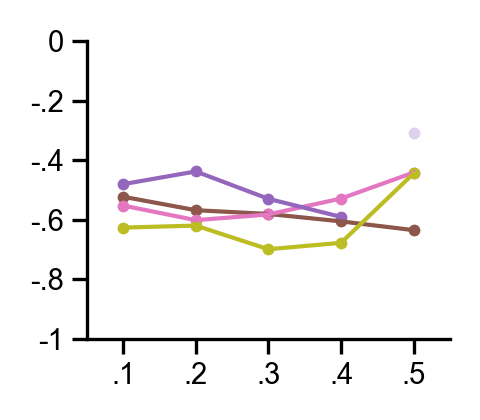

In [43]:
width = 1.4; height = 1.2

yticks = np.around(np.linspace(-1, 0, 6), 1)
xticks = xdata = thresholds
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0] - 0.05, xticks[-1] + 0.05)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

mask = p_countav_cb_reward < 0.05
ax.scatter(xdata[mask], corr_countav_cb_reward[mask], c='C5', s=8, lw=0)
ax.plot(xdata[mask], corr_countav_cb_reward[mask], lw=lw, c='C5')
mask = p_countav_cb_reward >= 0.05
ax.scatter(xdata[mask], corr_countav_cb_reward[mask], c='C5', alpha=0.3, s=8, lw=0)

mask = p_countaw_cb_reward < 0.05
ax.scatter(xdata[mask], corr_countaw_cb_reward[mask], c='C6', s=8, lw=0)
ax.plot(xdata[mask], corr_countaw_cb_reward[mask], lw=lw, c='C6')
mask = p_countaw_cb_reward >= 0.05
ax.scatter(xdata[mask], corr_countaw_cb_reward[mask], c='C6', alpha=0.3, s=8, lw=0)


mask = p_countb_cav_reward < 0.05
ax.scatter(xdata[mask], corr_countb_cav_reward[mask], c='C4', s=8, lw=0)
ax.plot(xdata[mask], corr_countb_cav_reward[mask], lw=lw, c='C4')
mask = p_countb_cav_reward >= 0.05
ax.scatter(xdata[mask], corr_countb_cav_reward[mask], c='C4', alpha=0.3, s=8, lw=0)

mask = p_countb_av_reward < 0.05
ax.scatter(xdata[mask], corr_countb_av_reward[mask], c='C8', s=8, lw=0)
ax.plot(xdata[mask], corr_countb_av_reward[mask], lw=lw, c='C8')
mask = p_countb_av_reward >= 0.05
ax.scatter(xdata[mask], corr_countb_av_reward[mask], c='C8', alpha=0.3, s=8, lw=0)

fig.tight_layout(pad=0, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='tuning_vs_reward_varythreshold'), orientation='portrait', format='pdf', transparent=True)

## 3A

In [44]:
def get_valuediff(b, critic):
    with torch.no_grad():
        u1 = torch.zeros(b.shape[0], b.shape[1], 2, device=b.device)
        u2 = torch.zeros(b.shape[0], b.shape[1], 2, device=b.device); u2[..., 0] = 1

        v_ = []
        for u in [u1, u2]:
            v = F.relu(critic.l1(torch.cat([b, u], dim=2)))
            v = F.relu(critic.l2(v))
            v = critic.l3(v)
            v_.append(v)

        v = v_[0] - v_[1]
        #v += v * self.value_noise_std * torch.randn_like(v)

    return v / 5

In [45]:
actorvalue_agent_values = []
for agent, states_ in zip(actorvalue_agents, actorvalue_data):
    actor = agent.actor; critic = agent.critic
    states = states_.state
    vs = []
    for state in states:
        x = state[..., :-1]
        with torch.no_grad():
            b, _ = critic.rnn1(x)
            v = get_valuediff(b, critic)
            
            v = v.squeeze(1).numpy()
            vs.append(v)
    actorvalue_agent_values.append(vs)

In [46]:
actornovalue_agent_values = []
for agent, states_ in zip(actornovalue_agents, actornovalue_data):
    actor = agent.actor; critic = agent.critic
    states = states_.state
    vs = []
    for state in states:
        x = state[..., :-1]
        with torch.no_grad():
            b, _ = critic.rnn1(x)
            v = get_valuediff(b, critic)
            
            v = v.squeeze(1).numpy()
            vs.append(v)
    actornovalue_agent_values.append(vs)

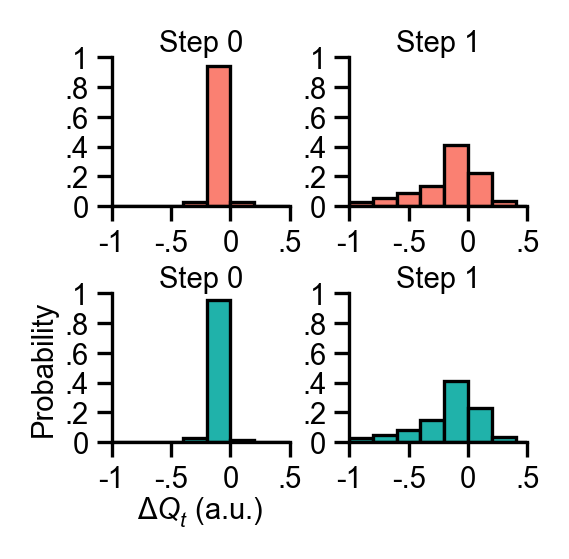

In [47]:
width = 1.7; height = 1.7

yticks = np.around(np.linspace(0, 1, 6), 1)
xticks = [-1, -0.5, 0., 0.5]

bins = np.linspace(-2, 2, 21)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(221)
ax.set_title('Step 0', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = np.hstack([np.hstack([trial[0].reshape(-1) for trial in df]) for df in actornovalue_agent_values])
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withoutvalue_c, edgecolor='k', lw=0.8)

ax = fig.add_subplot(222)
ax.set_title('Step 1', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = np.hstack([np.hstack([trial[1].reshape(-1) for trial in df]) for df in actornovalue_agent_values])
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withoutvalue_c, edgecolor='k', lw=0.8)

ax = fig.add_subplot(223)
ax.set_title('Step 0', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('$\Delta Q_{t}$ (a.u.)', fontsize=fontsize)
ax.set_ylabel('Probability', fontsize=fontsize)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.35)
ax.yaxis.set_label_coords(-0.3, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = np.hstack([np.hstack([trial[0].reshape(-1) for trial in df]) for df in actorvalue_agent_values])
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withvalue_c, edgecolor='k', lw=0.8)

ax = fig.add_subplot(224)
ax.set_title('Step 1', fontsize=fontsize, pad=0)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize + 1)
ax.set_ylabel('', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

data = np.hstack([np.hstack([trial[1].reshape(-1) for trial in df]) for df in actorvalue_agent_values])
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withvalue_c, edgecolor='k', lw=0.8)


fig.tight_layout(pad=0, w_pad=0, h_pad=0.2, rect=(0, -0.01, 1, 0.99))

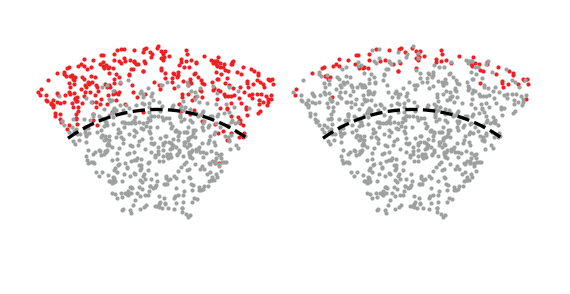

In [48]:
target_idexes = np.arange(0, 800)
i = -17
df = actornovalue_data[i]
value_diffs = actornovalue_agent_values[i]
fig = plt.figure(figsize=(1.7, 0.8), dpi=300)
    
ax = fig.add_subplot(121)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

skipped_idexes = np.hstack([v[1] for v in value_diffs]) > 0
skipped_idexes = skipped_idexes[:target_idexes.size]
for label, mask, c in zip(['Aborted', 'Attempted'], [skipped_idexes, ~skipped_idexes], 
                          [abort_c, attempt_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T, 
               c=c, marker='o', s=1, lw=0, label=label)
    
x = np.linspace(-165, 165)
y = np.sqrt((200 * np.sqrt(2))**2 - x**2)
ax.plot(x, y, lw=lw*0.8, c='k', ls='--')

    
ax = fig.add_subplot(122)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

skipped_idexes = df.skipped.iloc[target_idexes].values
skipped_idexes = skipped_idexes[:target_idexes.size]
for label, mask, c in zip(['Aborted', 'Attempted'], [skipped_idexes, ~skipped_idexes], 
                          [abort_c, attempt_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T, 
               c=c, marker='o', s=1, lw=0, label=label)
    
x = np.linspace(-165, 165)
y = np.sqrt((200 * np.sqrt(2))**2 - x**2)
ax.plot(x, y, lw=lw*0.8, c='k', ls='--')


fig.tight_layout(pad=0)

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='target_dist_novalue'), orientation='portrait', format='pdf', transparent=True)

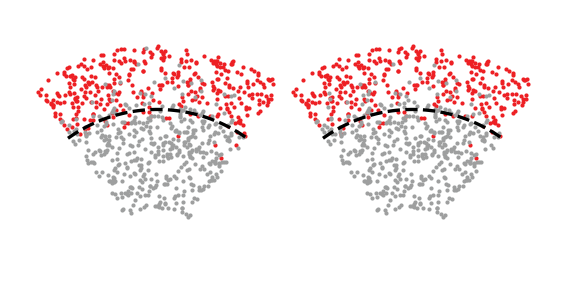

In [49]:
target_idexes = np.arange(0, 800)
i = 25
df = actorvalue_data[i]
value_diffs = actorvalue_agent_values[i]
fig = plt.figure(figsize=(1.7, 0.8), dpi=300)
    
ax = fig.add_subplot(121)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

skipped_idexes = np.hstack([v[1] for v in value_diffs]) > 0
skipped_idexes = skipped_idexes[:target_idexes.size]
for label, mask, c in zip(['Aborted', 'Attempted'], [skipped_idexes, ~skipped_idexes], 
                          [abort_c, attempt_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T, 
               c=c, marker='o', s=1, lw=0, label=label)
    
x = np.linspace(-165, 165)
y = np.sqrt((200 * np.sqrt(2))**2 - x**2)
ax.plot(x, y, lw=lw*0.8, c='k', ls='--')
    
ax = fig.add_subplot(122)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.xaxis.set_ticks([]); ax.axes.yaxis.set_ticks([])
ax.set_xlim([-235, 235]); ax.set_ylim([-2, 430])

skipped_idexes = df.skipped.iloc[target_idexes].values
skipped_idexes = skipped_idexes[:target_idexes.size]
for label, mask, c in zip(['Aborted', 'Attempted'], [skipped_idexes, ~skipped_idexes], 
                          [abort_c, attempt_c]):
    ax.scatter(*df.iloc[target_idexes].loc[mask, ['target_x', 'target_y']].values.T, 
               c=c, marker='o', s=1, lw=0, label=label)
    
x = np.linspace(-165, 165)
y = np.sqrt((200 * np.sqrt(2))**2 - x**2)
ax.plot(x, y, lw=lw*0.8, c='k', ls='--')

fig.tight_layout(pad=0)

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='target_dist_value'), orientation='portrait', format='pdf', transparent=True)

## 3B

In [50]:
actorvalue_isfartar = np.hstack([df.target_r > 200 * np.sqrt(2) for df in actorvalue_data])
actorvalue_isvalueskip = np.hstack([np.hstack([v2[1] for v2 in v1]) for v1 in actorvalue_agent_values]) > 0
actorvalue_isskipped = np.hstack([(df.skipped) for df in actorvalue_data])
df = pd.DataFrame({'dist': actorvalue_isfartar, 'value': actorvalue_isvalueskip, 'behv': actorvalue_isskipped})

actorvalue_distvalue_crosstab = pd.crosstab(df.value, df.dist)
actorvalue_distvalue_crosstab /= actorvalue_distvalue_crosstab.values.sum()
actorvalue_valuebehv_crosstab = pd.crosstab(df.behv, df.value)
actorvalue_valuebehv_crosstab /= actorvalue_valuebehv_crosstab.values.sum()

In [51]:
actornovalue_isfartar = np.hstack([df.target_r > 200 * np.sqrt(2) for df in actornovalue_data])
actornovalue_isvalueskip = np.hstack([np.hstack([v2[1] for v2 in v1]) for v1 in actornovalue_agent_values]) > 0
actornovalue_isskipped = np.hstack([(df.skipped) for df in actornovalue_data])
df = pd.DataFrame({'dist': actornovalue_isfartar, 'value': actornovalue_isvalueskip, 'behv': actornovalue_isskipped})

actornovalue_distvalue_crosstab = pd.crosstab(df.value, df.dist)
actornovalue_distvalue_crosstab /= actornovalue_distvalue_crosstab.values.sum()
actornovalue_valuebehv_crosstab = pd.crosstab(df.behv, df.value)
actornovalue_valuebehv_crosstab /= actornovalue_valuebehv_crosstab.values.sum()

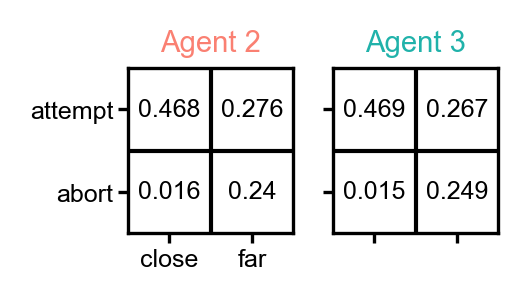

In [52]:
ticks = [0, 1]
fig = plt.figure(figsize=(1.7, 0.9), dpi=300)    
ax = fig.add_subplot(121)
ax.set_title('Agent 2', fontsize=fontsize, c=withoutvalue_c, pad=4)
plt.xticks(ticks, ['close', 'far'], fontsize=fontsize - 1)
plt.yticks(ticks, ['attempt', 'abort'], fontsize=fontsize - 1)
ax.set_xlabel(r'', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.xaxis.set_label_coords(0.5, -0.25)
ax.yaxis.set_label_coords(-0.57, 0.5)
ax.tick_params(axis='both', which='major', pad=1, length=2.5)

ax.imshow(actornovalue_distvalue_crosstab * 0, cmap='hot_r')
ax.plot([0.5, 0.5], [-0.5, 1.5], c='k', lw=lw)
ax.plot([-0.5, 1.5], [0.5, 0.5], c='k', lw=lw)
ax.text(0, 0, np.around(actornovalue_distvalue_crosstab.values[0, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 0, np.around(actornovalue_distvalue_crosstab.values[0, 1], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(0, 1, np.around(actornovalue_distvalue_crosstab.values[1, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 1, np.around(actornovalue_distvalue_crosstab.values[1, 1], 3), fontsize=fontsize - 1, ha='center', va='center')
    
ax = fig.add_subplot(122)
ax.set_title('Agent 3', fontsize=fontsize, c=withvalue_c, pad=4)
plt.xticks(ticks, ['', ''], fontsize=fontsize - 1)
plt.yticks(ticks, ['', ''], fontsize=fontsize - 1)
ax.set_xlabel(r'', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=1, length=2.5)

ax.imshow(actorvalue_distvalue_crosstab * 0, cmap='hot_r')
ax.plot([0.5, 0.5], [-0.5, 1.5], c='k', lw=lw)
ax.plot([-0.5, 1.5], [0.5, 0.5], c='k', lw=lw)
ax.text(0, 0, np.around(actorvalue_distvalue_crosstab.values[0, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 0, np.around(actorvalue_distvalue_crosstab.values[0, 1], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(0, 1, np.around(actorvalue_distvalue_crosstab.values[1, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 1, np.around(actorvalue_distvalue_crosstab.values[1, 1], 3), fontsize=fontsize - 1, ha='center', va='center')


fig.tight_layout(pad=0.5, w_pad=0.7, rect=(0, -0.01, 1, 0.99))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='crosstab1'), orientation='portrait', format='pdf', transparent=True)

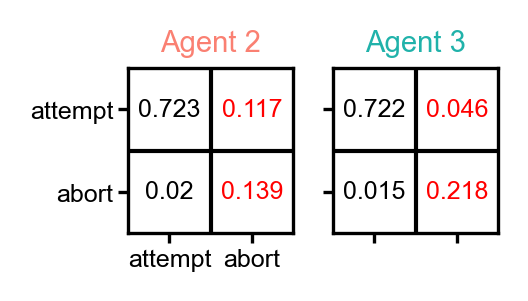

In [53]:
ticks = [0, 1]
fig = plt.figure(figsize=(1.7, 0.9), dpi=300)    
ax = fig.add_subplot(121)
ax.set_title('Agent 2', fontsize=fontsize, c=withoutvalue_c, pad=4)
plt.yticks(ticks, ['attempt', 'abort'], fontsize=fontsize - 1)
plt.xticks(ticks, ['attempt', 'abort'], fontsize=fontsize - 1)
ax.set_ylabel(r'', fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.xaxis.set_label_coords(0.5, -0.25)
ax.yaxis.set_label_coords(-0.57, 0.5)
ax.tick_params(axis='both', which='major', pad=1, length=2.5)

ax.imshow(actornovalue_valuebehv_crosstab * 0, cmap='hot_r')
ax.plot([0.5, 0.5], [-0.5, 1.5], c='k', lw=lw)
ax.plot([-0.5, 1.5], [0.5, 0.5], c='k', lw=lw)
ax.text(0, 0, np.around(actornovalue_valuebehv_crosstab.values[0, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 0, np.around(actornovalue_valuebehv_crosstab.values[0, 1], 3), fontsize=fontsize - 1, ha='center', va='center',
        c='r')
ax.text(0, 1, np.around(actornovalue_valuebehv_crosstab.values[1, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 1, np.around(actornovalue_valuebehv_crosstab.values[1, 1], 3), fontsize=fontsize - 1, ha='center', va='center', 
        c='r')
    
ax = fig.add_subplot(122)
ax.set_title('Agent 3', fontsize=fontsize, c=withvalue_c, pad=4)
plt.xticks(ticks, ['', ''], fontsize=fontsize - 1)
plt.yticks(ticks, ['', ''], fontsize=fontsize - 1)
ax.set_xlabel(r'', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)
ax.tick_params(axis='both', which='major', pad=1, length=2.5)

ax.imshow(actorvalue_valuebehv_crosstab * 0, cmap='hot_r')
ax.plot([0.5, 0.5], [-0.5, 1.5], c='k', lw=lw)
ax.plot([-0.5, 1.5], [0.5, 0.5], c='k', lw=lw)
ax.text(0, 0, np.around(actorvalue_valuebehv_crosstab.values[0, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 0, np.around(actorvalue_valuebehv_crosstab.values[0, 1], 3), fontsize=fontsize - 1, ha='center', va='center',
        c='r')
ax.text(0, 1, np.around(actorvalue_valuebehv_crosstab.values[1, 0], 3), fontsize=fontsize - 1, ha='center', va='center')
ax.text(1, 1, np.around(actorvalue_valuebehv_crosstab.values[1, 1], 3), fontsize=fontsize - 1, ha='center', va='center', 
        c='r')


fig.tight_layout(pad=0.5, w_pad=0.7, rect=(0, -0.01, 1, 0.99))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='crosstab2'), orientation='portrait', format='pdf', transparent=True)

## 3C

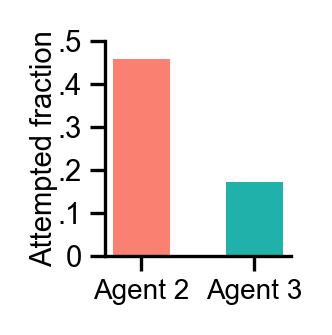

In [54]:
width = 1; height = 1

yticks = np.around(np.linspace(0, 0.5, 6), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Attempted fraction', fontsize=fontsize)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

species = ("Agent 2", "Agent 3")
barwidth = 0.5

d1 = actornovalue_valuebehv_crosstab.values[:, 1]
d1 /= d1.sum()
d2 = actorvalue_valuebehv_crosstab.values[:, 1]
d2 /= d2.sum()
p = ax.bar(species, [d1[0], d2[0]], barwidth, color=[withoutvalue_c, withvalue_c])
    
plt.xticks(fontsize=fontsize-0.3)

#ax.legend(fontsize=fontsize - 1, frameon=False, loc=[1, 0], 
#          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))
    
#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='incongruency'), orientation='portrait', format='pdf', transparent=True)

In [55]:
d1[0], d2[0]

(0.4572044820874322, 0.1729627105442508)

## 2I

In [56]:
reward_rate_value =  np.array([df.rewarded.sum() / ((np.hstack(df.pos_x).size - len(df)) * arg.DT)
                               for df in actorvalue_data])
reward_rate_novalue =  np.array([df.rewarded.sum() / ((np.hstack(df.pos_x).size - len(df)) * arg.DT)
                                 for df in actornovalue_data])
reward_rate_holistic =  np.array([df.rewarded.sum() / ((np.hstack(df.pos_x).size - len(df)) * arg.DT)
                                 for df in actorholistic_data])
reward_rate_holisticLong =  np.array([df.rewarded.sum() / ((np.hstack(df.pos_x).size - len(df)) * arg.DT)
                                 for df in actorholisticLong_data])

skip_diff_value = np.array([df.skipped.sum() / len(df) for df in actorvalue_data])
skip_diff_novalue = np.array([df.skipped.sum() / len(df) for df in actornovalue_data])
skip_diff_holistic = np.array([df.skipped.sum() / len(df) for df in actorholistic_data])
skip_diff_holisticLong = np.array([df.skipped.sum() / len(df) for df in actorholisticLong_data])
badseedidces_novalue = np.where(okseed_mask_novalue)[0][np.where(reward_rate_novalue < 0.6)[0]]
badseedidces_holistic = np.where(okseed_mask_holistic)[0][np.where(reward_rate_holistic < 0.6)[0]]
badseedidces_holisticLong = np.where(okseed_mask_holisticLong)[0][np.where(reward_rate_holisticLong < 0.6)[0]]

PearsonRResult(statistic=0.954236825352121, pvalue=5.454920239255845e-21) 0.2769132097862748
PearsonRResult(statistic=-0.19870830760755714, pvalue=0.23839342357405782) -0.08274283141651055
PearsonRResult(statistic=-0.4440149562008941, pvalue=0.023066967866919436) -0.3128674011433585


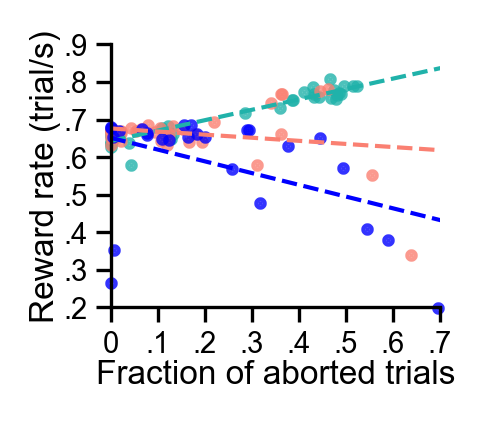

In [57]:
width = 1.5; height = 1.3

xticks = np.around(np.linspace(0, 0.7, 8), 1)
yticks = np.around(np.linspace(0.2, 0.9, 8), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel(r'Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlabel('Fraction of aborted trials', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

ax.scatter(skip_diff_value, reward_rate_value, c=withvalue_c, s=1, alpha=0.8, lw=2, clip_on=False)
model = LinearRegression()
model.fit(skip_diff_value.reshape(-1, 1), reward_rate_value)
xdata = np.linspace(0, 1, 100).reshape(-1, 1)
ydata = model.predict(xdata)
ax.plot(xdata.reshape(-1), ydata, lw=lw, c=withvalue_c, ls='--')
print(pearsonr(skip_diff_value, reward_rate_value), model.coef_[0])

ax.scatter(skip_diff_novalue, reward_rate_novalue, c=withoutvalue_c, s=1, alpha=0.8, lw=2, clip_on=False)
model = LinearRegression()
model.fit(skip_diff_novalue.reshape(-1, 1), reward_rate_novalue)
xdata = np.linspace(0, 1, 100).reshape(-1, 1)
ydata = model.predict(xdata)
ax.plot(xdata.reshape(-1), ydata, lw=lw, c=withoutvalue_c, ls='--')
print(pearsonr(skip_diff_novalue, reward_rate_novalue), model.coef_[0])

ax.scatter(skip_diff_holistic, reward_rate_holistic, c=holistic_c, s=1, alpha=0.8, lw=2, clip_on=False)
model = LinearRegression()
model.fit(skip_diff_holistic.reshape(-1, 1), reward_rate_holistic)
xdata = np.linspace(0, 1, 100).reshape(-1, 1)
ydata = model.predict(xdata)
ax.plot(xdata.reshape(-1), ydata, lw=lw, c=holistic_c, ls='--')
print(pearsonr(skip_diff_holistic, reward_rate_holistic), model.coef_[0])

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='reward_vs_abort'), orientation='portrait', format='pdf', transparent=True)

## S3J

PearsonRResult(statistic=0.954236825352121, pvalue=5.454920239255845e-21) 0.2769132097862748
PearsonRResult(statistic=-0.19870830760755714, pvalue=0.23839342357405782) -0.08274283141651055
PearsonRResult(statistic=-0.22329510075508, pvalue=0.1972563457069515) -0.13560303509274105


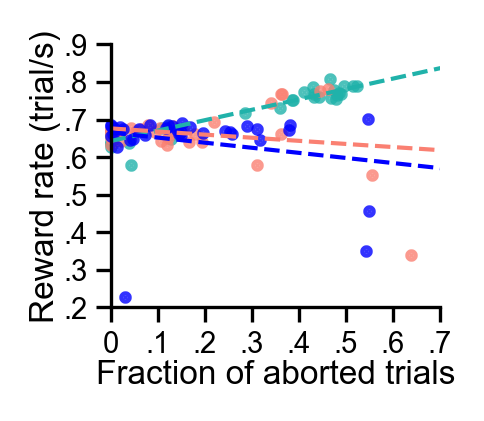

In [58]:
width = 1.5; height = 1.3

xticks = np.around(np.linspace(0, 0.7, 8), 1)
yticks = np.around(np.linspace(0.2, 0.9, 8), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel(r'Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlabel('Fraction of aborted trials', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

ax.scatter(skip_diff_value, reward_rate_value, c=withvalue_c, s=1, alpha=0.8, lw=2, clip_on=False)
model = LinearRegression()
model.fit(skip_diff_value.reshape(-1, 1), reward_rate_value)
xdata = np.linspace(0, 1, 100).reshape(-1, 1)
ydata = model.predict(xdata)
ax.plot(xdata.reshape(-1), ydata, lw=lw, c=withvalue_c, ls='--')
print(pearsonr(skip_diff_value, reward_rate_value), model.coef_[0])

ax.scatter(skip_diff_novalue, reward_rate_novalue, c=withoutvalue_c, s=1, alpha=0.8, lw=2, clip_on=False)
model = LinearRegression()
model.fit(skip_diff_novalue.reshape(-1, 1), reward_rate_novalue)
xdata = np.linspace(0, 1, 100).reshape(-1, 1)
ydata = model.predict(xdata)
ax.plot(xdata.reshape(-1), ydata, lw=lw, c=withoutvalue_c, ls='--')
print(pearsonr(skip_diff_novalue, reward_rate_novalue), model.coef_[0])

ax.scatter(skip_diff_holisticLong, reward_rate_holisticLong, c=holistic_c, s=1, alpha=0.8, lw=2, clip_on=False)
model = LinearRegression()
model.fit(skip_diff_holisticLong.reshape(-1, 1), reward_rate_holisticLong)
xdata = np.linspace(0, 1, 100).reshape(-1, 1)
ydata = model.predict(xdata)
ax.plot(xdata.reshape(-1), ydata, lw=lw, c=holistic_c, ls='--')
print(pearsonr(skip_diff_holisticLong, reward_rate_holisticLong), model.coef_[0])

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#            name='reward_vs_abort_long'), orientation='portrait', format='pdf', transparent=True)

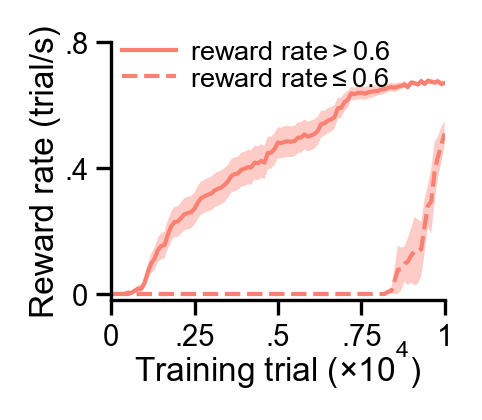

In [255]:
width = 1.5; height = 1.3
MAX_TRAINING_T = 10000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.8, 3), 2)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0]-0.02, yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = actorvalue_agents_training_progress[0].episode.values
mask = np.array(list(set(np.where(okseed_mask_novalue)[0]) - set(badseedidces_novalue)))
for ymean, ysem, ls, label in zip([actornovalue_agents_reward_rate[mask, :].mean(axis=0),
                                   actornovalue_agents_reward_rate[badseedidces_novalue].mean(axis=0)], 
                                  [sem(actornovalue_agents_reward_rate[mask, :], axis=0),
                                   sem(actornovalue_agents_reward_rate[badseedidces_novalue], axis=0)],
                                  ['-', '--'],
                                  ['reward rate$>0.6$', 'reward rate$\leq 0.6$']):
    ax.plot(xdata, ymean, lw=lw, clip_on=True, c=withoutvalue_c, label=label, ls=ls)
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=withoutvalue_c, alpha=0.4)

ax.legend(fontsize=fontsize - 0.5, frameon=False, loc=[0.0, 0.77], 
          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_training_badseeds'), orientation='portrait', format='pdf', transparent=True)

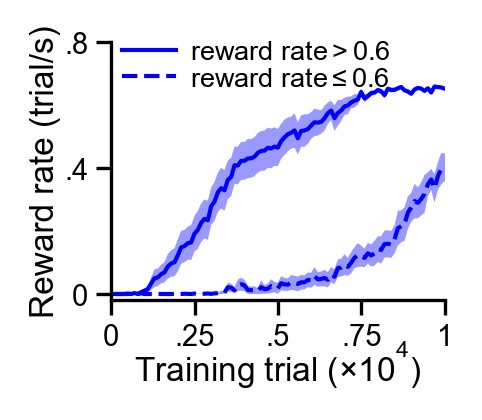

In [256]:
width = 1.5; height = 1.3
MAX_TRAINING_T = 10000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.8, 3), 2)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0]-0.02, yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = actorholistic_agents_training_progress[0].episode.values
mask = np.array(list(set(np.where(okseed_mask_holistic)[0]) - set(badseedidces_holistic)))
for ymean, ysem, ls, label in zip([actorholistic_agents_reward_rate[mask, :].mean(axis=0),
                                   actorholistic_agents_reward_rate[badseedidces_holistic].mean(axis=0)], 
                                  [sem(actorholistic_agents_reward_rate[mask, :], axis=0),
                                   sem(actorholistic_agents_reward_rate[badseedidces_holistic], axis=0)],
                                  ['-', '--'],
                                  ['reward rate$>0.6$', 'reward rate$\leq 0.6$']):
    ax.plot(xdata, ymean, lw=lw, clip_on=True, c=holistic_c, label=label, ls=ls)
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=holistic_c, alpha=0.4)

ax.legend(fontsize=fontsize - 0.5, frameon=False, loc=[0.0, 0.77], 
          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_training_badseeds_holistic'), orientation='portrait', format='pdf', transparent=True)

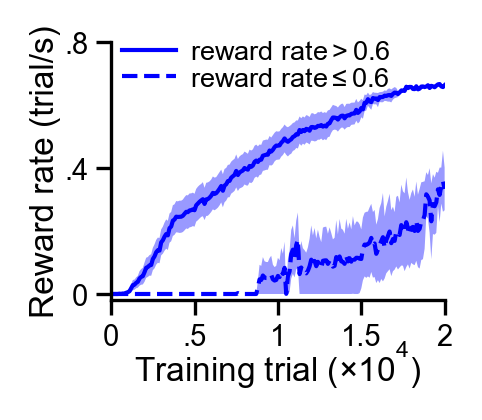

In [257]:
width = 1.5; height = 1.3
MAX_TRAINING_T = 20000

xaxis_scale = int(1e4)
yticks = np.around(np.linspace(0, 0.8, 3), 2)
xticks = np.linspace(0, MAX_TRAINING_T, 5)
xticklabels = [my_tickformatter(i, None) for i in xticks / xaxis_scale]
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, xticklabels, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel(r'Training trial ($\times$10$^4$)', fontsize=fontsize + 1)
ax.set_ylabel('Reward rate (trial/s)', fontsize=fontsize + 1)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_ylim(yticks[0]-0.02, yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='both', which='major', pad=2)

xdata = actorholistic_agents_training_progress[0].episode.values
mask = np.array(list(set(np.where(okseed_mask_holisticLong)[0]) - set(badseedidces_holisticLong)))
for ymean, ysem, ls, label in zip([actorholistic_agents_reward_rate[mask, :].mean(axis=0),
                                   actorholistic_agents_reward_rate[badseedidces_holisticLong].mean(axis=0)], 
                                  [sem(actorholistic_agents_reward_rate[mask, :], axis=0),
                                   sem(actorholistic_agents_reward_rate[badseedidces_holisticLong], axis=0)],
                                  ['-', '--'],
                                  ['reward rate$>0.6$', 'reward rate$\leq 0.6$']):
    ax.plot(xdata, ymean, lw=lw, clip_on=True, c=holistic_c, label=label, ls=ls)
    ax.fill_between(xdata, ymean - ysem, ymean + ysem,
                    edgecolor='None', facecolor=holistic_c, alpha=0.4)

ax.legend(fontsize=fontsize - 0.5, frameon=False, loc=[0.0, 0.77], 
          handletextpad=0.5, labelspacing=0.1, ncol=1, columnspacing=1)

fig.tight_layout(pad=0.3, w_pad=0.5, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='reward_rate_training_badseeds_holisticLong'), orientation='portrait', format='pdf', transparent=True)

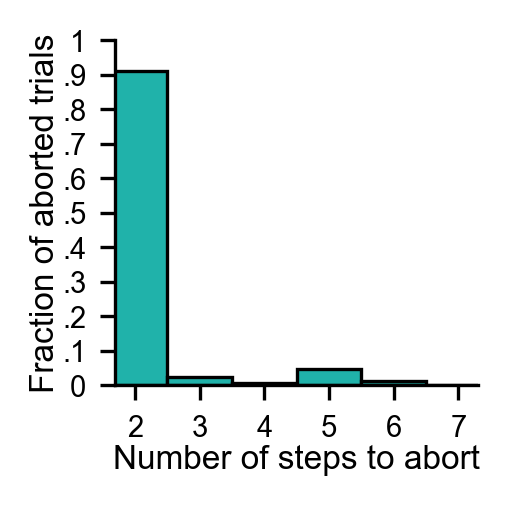

In [247]:
width = 1.5; height = 1.5

yticks = np.around(np.linspace(0, 1, 11), 1)
xticks = np.around(np.arange(2, 8, 1), 1)
    
fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks(xticks, fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_xlabel('Number of steps to abort', fontsize=fontsize + 1)
ax.set_ylabel('Fraction of aborted trials', fontsize=fontsize + 1)
ax.set_xlim(xticks[0] - 0.3, xticks[-1] + 0.3)
ax.set_ylim(yticks[0], yticks[-1])
ax.xaxis.set_label_coords(0.5, -0.17)
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.yaxis.set_major_formatter(major_formatter)
ax.xaxis.set_major_formatter(major_formatter)

bins = np.linspace(2, 9, 8) - 0.5
data = np.hstack([[trial.size for trial in df[df.skipped].pos_x] for df in actorvalue_data])
weights = np.ones_like(data) / len(data)
ax.hist(data, weights=weights, bins=bins, alpha=1, histtype='bar', color=withvalue_c, edgecolor='k', lw=0.8)


fig.tight_layout(pad=0.05, w_pad=0, rect=(0, 0, 1, 1))

#plt.savefig(figure_path / 'raw' / '{name}.pdf'.format(
#    name='abort_step_dist_value'), orientation='portrait', format='pdf', transparent=True)